🎥 ДОСТУПНЫЕ ВАРИАНТЫ ОБРАБОТКИ ВИДЕО:
1. 📊 БАЗОВЫЙ АНАЛИЗ - Классификация основных сцен
2. 🔍 ДЕТЕКТИРОВАНИЕ ОБЪЕКТОВ - Поиск конкретных объектов на улице
3. 🚶 АНАЛИЗ АКТИВНОСТИ - Что происходит в видео
4. ⭐ ПОИСК КЛЮЧЕВЫХ МОМЕНТОВ - Важные и интересные сцены
5. 📈 ПОЛНЫЙ ОТЧЕТ - Комплексный анализ всего видео
6. 🎯 ПОЛЬЗОВАТЕЛЬСКИЙ АНАЛИЗ - Свои классы для анализа



🎯 Выберите вариант анализа (1-6):  5


🚀 Используется устройство: cuda
✅ CLIP модель загружена!

🎬 ЗАПУСК: Комплексный анализ всего видео
🎯 Запуск ПОЛНОГО АНАЛИЗА...
📹 Информация о видео:
   ⏱️ Длительность: 13.8 сек
   📊 Разрешение: 768x432
   🎞️ Всего кадров: 344
   🔍 Анализируемых классов: 16
   ⚡ Семплирование: каждый 50-й кадр

🔍 Начинаем анализ кадров...
✅ Анализ завершен! Обработано кадров: 7

📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ: Комплексный анализ всего видео
📈 СТАТИСТИКА ПО КЛАССАМ:
   pedestrian area: 5 кадров (71.4%)
   urban street: 2 кадров (28.6%)

⏱️ ВРЕМЕННАЯ ШКАЛА АКТИВНОСТИ:
   00:00-00:59 - pedestrian area


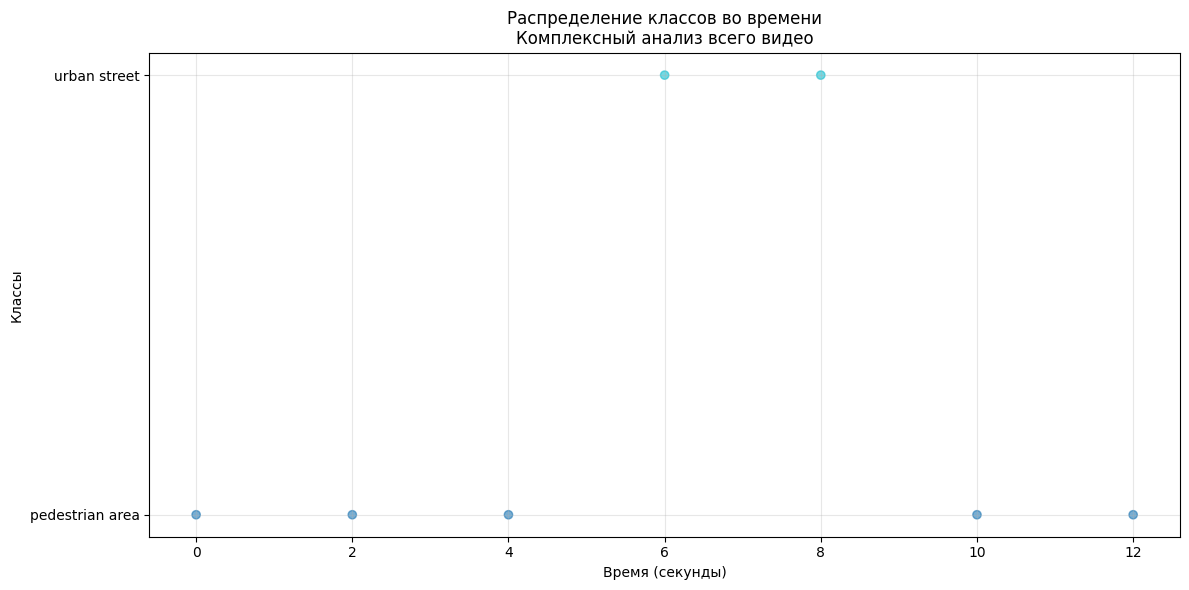

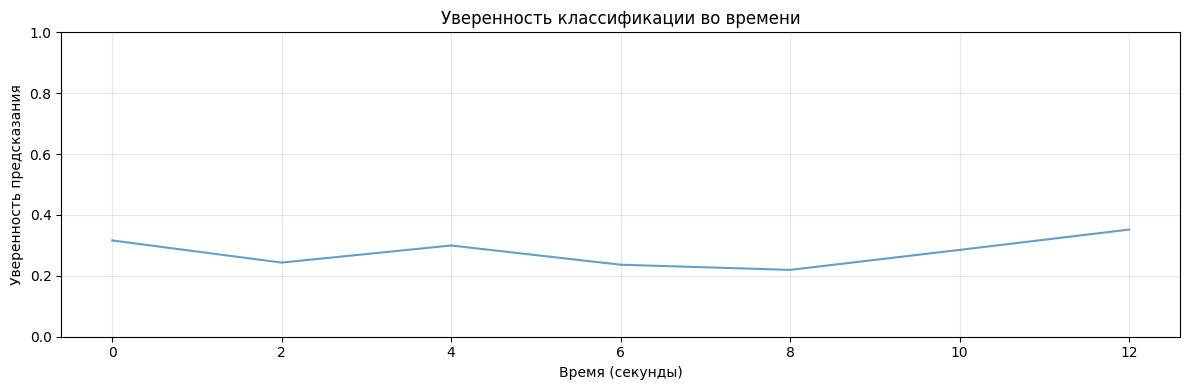

💾 Результаты сохранены в: video_analysis_results/street_2_Комплексный_анализ_всего_видео.json

✅ Анализ завершен успешно!
📊 Проанализировано сцен: 7
🎯 Тип анализа: Комплексный анализ всего видео


In [6]:
# Установи библиотеки если нужно
# !pip install opencv-python matplotlib torch transformers

import cv2
import torch
from transformers import CLIPModel, CLIPProcessor
import numpy as np
from PIL import Image
import os
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import json

# =============================================================================
# 🎯 ВАРИАНТЫ ОБРАБОТКИ ВИДЕО
# =============================================================================

def show_analysis_options():
    """Показывает доступные варианты анализа"""
    print("🎥 ДОСТУПНЫЕ ВАРИАНТЫ ОБРАБОТКИ ВИДЕО:")
    print("=" * 50)
    
    options = {
        "1": "📊 БАЗОВЫЙ АНАЛИЗ - Классификация основных сцен",
        "2": "🔍 ДЕТЕКТИРОВАНИЕ ОБЪЕКТОВ - Поиск конкретных объектов на улице", 
        "3": "🚶 АНАЛИЗ АКТИВНОСТИ - Что происходит в видео",
        "4": "⭐ ПОИСК КЛЮЧЕВЫХ МОМЕНТОВ - Важные и интересные сцены",
        "5": "📈 ПОЛНЫЙ ОТЧЕТ - Комплексный анализ всего видео",
        "6": "🎯 ПОЛЬЗОВАТЕЛЬСКИЙ АНАЛИЗ - Свои классы для анализа"
    }
    
    for key, value in options.items():
        print(f"{key}. {value}")
    
    print("=" * 50)
    return options

# =============================================================================
# 🚀 ОСНОВНЫЕ ФУНКЦИИ АНАЛИЗА
# =============================================================================

def initialize_clip():
    """Инициализация CLIP модели"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🚀 Используется устройство: {device}")
    
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    print("✅ CLIP модель загружена!")
    
    return model, processor, device

def analyze_frame(frame, classes, model, processor, device):
    """Анализ одного кадра с CLIP"""
    # Конвертируем BGR в RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(frame_rgb)
    
    # Подготавливаем текстовые описания
    text_descriptions = [f"a photo of {cls}" for cls in classes]
    
    # Обрабатываем данные
    inputs = processor(
        text=text_descriptions, 
        images=pil_image, 
        return_tensors="pt", 
        padding=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Получаем предсказания
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)[0]
    
    # Лучший класс
    best_idx = probs.argmax().item()
    best_confidence = probs[best_idx].item()
    
    # Возвращаем все вероятности для детального анализа
    return classes[best_idx], best_confidence, probs.cpu().numpy()

def get_video_info(video_path):
    """Получение информации о видео"""
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    cap.release()
    
    return {
        'fps': fps,
        'total_frames': total_frames,
        'duration': duration,
        'resolution': f"{width}x{height}"
    }

# =============================================================================
# 📊 ВАРИАНТЫ АНАЛИЗА
# =============================================================================

def basic_analysis(video_path, model, processor, device):
    """📊 Базовый анализ - классификация основных сцен"""
    print("🎯 Запуск БАЗОВОГО АНАЛИЗА...")
    
    classes = [
        "urban street with buildings", "road with vehicles", "pedestrian area", 
        "residential area", "commercial area", "park or green area",
        "empty street", "crowded street", "traffic jam", "intersection"
    ]
    
    return process_video_with_classes(video_path, classes, model, processor, device, "Базовый анализ")

def object_detection_analysis(video_path, model, processor, device):
    """🔍 Детектирование объектов - поиск конкретных объектов"""
    print("🎯 Запуск ДЕТЕКТИРОВАНИЯ ОБЪЕКТОВ...")
    
    classes = [
        "car", "bus", "truck", "motorcycle", "bicycle", "pedestrian",
        "traffic light", "street sign", "building", "tree", 
        "parked vehicle", "moving vehicle", "person walking", 
        "crosswalk", "street lights"
    ]
    
    return process_video_with_classes(video_path, classes, model, processor, device, "Детектирование объектов")

def activity_analysis(video_path, model, processor, device):
    """🚶 Анализ активности - что происходит в видео"""
    print("🎯 Запуск АНАЛИЗА АКТИВНОСТИ...")
    
    classes = [
        "heavy traffic", "light traffic", "pedestrians crossing",
        "vehicles moving", "vehicles stopped", "people waiting",
        "construction work", "street cleaning", "delivery activity",
        "public transportation", "emergency vehicles", "normal flow"
    ]
    
    return process_video_with_classes(video_path, classes, model, processor, device, "Анализ активности")

def keyframes_analysis(video_path, model, processor, device):
    """⭐ Поиск ключевых моментов - важные сцены"""
    print("🎯 Запуск ПОИСКА КЛЮЧЕВЫХ МОМЕНТОВ...")
    
    classes = [
        "accident or crash", "unusual event", "police activity",
        "ambulance or emergency", "construction zone", "parade or event",
        "protest or gathering", "celebrity sighting", "beautiful sunset",
        "interesting architecture", "crowd gathering", "empty scene"
    ]
    
    results = process_video_with_classes(video_path, classes, model, processor, device, "Ключевые моменты")
    
    # Фильтруем только интересные моменты (высокая уверенность в необычных классах)
    interesting_classes = ["accident or crash", "unusual event", "police activity", "ambulance or emergency"]
    key_moments = []
    
    for result in results:
        if result['class'] in interesting_classes and result['confidence'] > 0.3:
            key_moments.append(result)
    
    print(f"⭐ Найдено ключевых моментов: {len(key_moments)}")
    return key_moments

def full_analysis(video_path, model, processor, device):
    """📈 Полный отчет - комплексный анализ"""
    print("🎯 Запуск ПОЛНОГО АНАЛИЗА...")
    
    # Комбинируем классы из всех анализов
    classes = [
        # Из базового анализа
        "urban street", "road with vehicles", "pedestrian area", "residential area",
        # Из детектирования объектов  
        "car", "bus", "pedestrian", "traffic light", "building",
        # Из анализа активности
        "heavy traffic", "light traffic", "vehicles moving", "people waiting",
        # Из ключевых моментов
        "unusual event", "emergency vehicles", "crowd gathering"
    ]
    
    return process_video_with_classes(video_path, classes, model, processor, device, "Полный анализ")

def custom_analysis(video_path, custom_classes, model, processor, device):
    """🎯 Пользовательский анализ - свои классы"""
    print("🎯 Запуск ПОЛЬЗОВАТЕЛЬСКОГО АНАЛИЗА...")
    
    if not custom_classes:
        custom_classes = ["car", "person", "building", "tree", "sky"]
    
    return process_video_with_classes(video_path, custom_classes, model, processor, device, "Пользовательский анализ")

# =============================================================================
# 🎥 ОСНОВНАЯ ФУНКЦИЯ ОБРАБОТКИ ВИДЕО
# =============================================================================

def process_video_with_classes(video_path, classes, model, processor, device, analysis_name):
    """Обрабатывает видео с заданными классами"""
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Ошибка открытия видео: {video_path}")
        return []
    
    # Получаем информацию о видео
    video_info = get_video_info(video_path)
    print(f"📹 Информация о видео:")
    print(f"   ⏱️ Длительность: {video_info['duration']:.1f} сек")
    print(f"   📊 Разрешение: {video_info['resolution']}")
    print(f"   🎞️ Всего кадров: {video_info['total_frames']}")
    print(f"   🔍 Анализируемых классов: {len(classes)}")
    
    # Настройки семплирования (анализируем каждый N-й кадр)
    sample_interval = max(1, int(video_info['fps'] * 2))  # Каждые 2 секунды
    print(f"   ⚡ Семплирование: каждый {sample_interval}-й кадр")
    
    results = []
    frame_count = 0
    analyzed_frames = 0
    
    print("\n🔍 Начинаем анализ кадров...")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Анализируем только каждый sample_interval кадр
        if frame_count % sample_interval == 0:
            timestamp = frame_count / video_info['fps']
            
            best_class, confidence, all_probs = analyze_frame(frame, classes, model, processor, device)
            
            results.append({
                'timestamp': timestamp,
                'frame': frame_count,
                'class': best_class,
                'confidence': confidence,
                'all_probabilities': dict(zip(classes, all_probs))
            })
            
            analyzed_frames += 1
            if analyzed_frames % 10 == 0:
                print(f"   📊 Проанализировано кадров: {analyzed_frames}")
            
        frame_count += 1
    
    cap.release()
    print(f"✅ Анализ завершен! Обработано кадров: {analyzed_frames}")
    
    return results

# =============================================================================
# 📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# =============================================================================

def visualize_results(results, analysis_name, video_info):
    """Визуализация результатов анализа"""
    
    if not results:
        print("❌ Нет результатов для визуализации")
        return
    
    print(f"\n📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ: {analysis_name}")
    print("=" * 60)
    
    # Статистика по классам
    class_counter = Counter([r['class'] for r in results])
    total_frames = len(results)
    
    print("📈 СТАТИСТИКА ПО КЛАССАМ:")
    for class_name, count in class_counter.most_common():
        percentage = (count / total_frames) * 100
        print(f"   {class_name}: {count} кадров ({percentage:.1f}%)")
    
    # Временная шкала
    print(f"\n⏱️ ВРЕМЕННАЯ ШКАЛА АКТИВНОСТИ:")
    time_intervals = defaultdict(list)
    
    for result in results:
        minute = int(result['timestamp'] // 60)
        time_intervals[minute].append(result['class'])
    
    for minute in sorted(time_intervals.keys()):
        most_common_class = Counter(time_intervals[minute]).most_common(1)[0][0]
        print(f"   {minute:02d}:00-{minute:02d}:59 - {most_common_class}")
    
    # График распределения классов во времени
    plt.figure(figsize=(12, 6))
    
    timestamps = [r['timestamp'] for r in results]
    classes = [r['class'] for r in results]
    
    # Создаем числовые метки для классов
    unique_classes = list(set(classes))
    class_to_num = {cls: i for i, cls in enumerate(unique_classes)}
    class_nums = [class_to_num[cls] for cls in classes]
    
    plt.scatter(timestamps, class_nums, c=class_nums, cmap='tab10', alpha=0.6)
    plt.yticks(range(len(unique_classes)), unique_classes)
    plt.xlabel('Время (секунды)')
    plt.ylabel('Классы')
    plt.title(f'Распределение классов во времени\n{analysis_name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # График уверенности
    plt.figure(figsize=(12, 4))
    confidences = [r['confidence'] for r in results]
    plt.plot(timestamps, confidences, alpha=0.7)
    plt.xlabel('Время (секунды)')
    plt.ylabel('Уверенность предсказания')
    plt.title('Уверенность классификации во времени')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def save_results_to_file(results, analysis_name, video_path):
    """Сохранение результатов в файл"""
    if not results:
        return
    
    output_dir = "video_analysis_results"
    os.makedirs(output_dir, exist_ok=True)
    
    video_name = Path(video_path).stem
    output_file = os.path.join(output_dir, f"{video_name}_{analysis_name.replace(' ', '_')}.json")
    
    # Конвертируем numpy типы в стандартные Python типы
    serializable_results = []
    for result in results:
        serializable_result = {
            'timestamp': float(result['timestamp']),
            'frame': int(result['frame']),
            'class': result['class'],
            'confidence': float(result['confidence']),
            'all_probabilities': {k: float(v) for k, v in result['all_probabilities'].items()}
        }
        serializable_results.append(serializable_result)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(serializable_results, f, indent=2, ensure_ascii=False)
    
    print(f"💾 Результаты сохранены в: {output_file}")

# =============================================================================
# 🎯 ГЛАВНАЯ ФУНКЦИЯ
# =============================================================================

def main():
    """Основная функция программы"""
    
    # Путь к видеофайлу
    video_path = "/home/oleg/projects/ML/CLIP/video/street_2.mp4"
    
    # Проверяем существование файла
    if not os.path.exists(video_path):
        print(f"❌ Видеофайл не найден: {video_path}")
        print("💡 Убедитесь, что путь правильный и файл существует")
        return
    
    # Показываем варианты анализа
    options = show_analysis_options()
    
    # Выбор варианта анализа
    try:
        choice = input("\n🎯 Выберите вариант анализа (1-6): ").strip()
        
        if choice not in options:
            print("❌ Неверный выбор! Запускаю базовый анализ...")
            choice = "1"
            
    except KeyboardInterrupt:
        print("\n👋 Программа прервана пользователем")
        return
    
    # Инициализация CLIP
    model, processor, device = initialize_clip()
    
    # Получаем информацию о видео
    video_info = get_video_info(video_path)
    
    # Выполняем выбранный анализ
    analysis_functions = {
        "1": basic_analysis,
        "2": object_detection_analysis, 
        "3": activity_analysis,
        "4": keyframes_analysis,
        "5": full_analysis,
        "6": lambda v, m, p, d: custom_analysis(v, None, m, p, d)
    }
    
    analysis_function = analysis_functions[choice]
    analysis_name = options[choice].split(" - ")[1]
    
    print(f"\n🎬 ЗАПУСК: {analysis_name}")
    print("=" * 60)
    
    # Запускаем анализ
    results = analysis_function(video_path, model, processor, device)
    
    # Визуализируем результаты
    visualize_results(results, analysis_name, video_info)
    
    # Сохраняем результаты
    save_results_to_file(results, analysis_name, video_path)
    
    print(f"\n✅ Анализ завершен успешно!")
    print(f"📊 Проанализировано сцен: {len(results)}")
    print(f"🎯 Тип анализа: {analysis_name}")

# Запуск программы
if __name__ == "__main__":
    main()